In [1]:
import os, sys, re, gc, glob

# set working dir
WORKING_DIR = re.sub('jdi-qasp-ml.*$','',os.path.normpath(os.getcwd())) + 'jdi-qasp-ml'
os.chdir(WORKING_DIR)

import torch
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm, trange
from sklearn.metrics import confusion_matrix
import json

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

from tqdm.auto import tqdm, trange
from utils import JDNDataset, JDIModel, get_grey_image, assign_labels, logger, maximize_window, DatasetBuilder, load_gray_image
from time import sleep
from flask import jsonify

import datetime as dt
import requests

START_DT = dt.datetime.now()

2021-06-20 01:17:13,539 -INFO - config:config.py:16 - Module utils.config was loaded
2021-06-20 01:17:13,541 -INFO - common:common.py:618 - Module utils.common is loaded...
2021-06-20 01:17:13,542 -INFO - hidden:hidden.py:121 - hidden module is loaded
2021-06-20 01:17:13,548 -INFO - features_builder:features_builder.py:305 - feature_bilder module is loaded...
2021-06-20 01:17:13,549 -INFO - dataset_builder:dataset_builder.py:207 - dataset package is loaded...
2021-06-20 01:17:13,551 -INFO - dataset:dataset.py:277 - dataset module is loaded...


In [2]:
SITE_URL = 'https://www.cnn.com/'

SAVE_SCREEN = True
WAIT_TIME_SECONDS = 7
HEADLESS = True #False

PREDICT_URL = 'http://localhost:5000/predict'
DATASET_NAME = 'cnews'


### getting json

2021-06-20 01:17:13,861 -INFO - dataset_builder:dataset_builder.py:77 - Dataset name: cnews
2021-06-20 01:17:13,862 -INFO - dataset_builder:dataset_builder.py:86 - Create directories to save the dataset
2021-06-20 01:17:13,863 -INFO - dataset_builder:dataset_builder.py:123 - Creating driver
2021-06-20 01:17:15,017 -INFO - dataset_builder:dataset_builder.py:131 - Chrome web driver is created
2021-06-20 01:17:15,138 -INFO - <ipython-input-3-1703c48867d9>:<ipython-input-3-1703c48867d9>:10 - getting url: https://www.cnn.com/
2021-06-20 01:17:22,872 -INFO - common:common.py:75 - Window maximized
2021-06-20 01:17:22,873 -INFO - dataset_builder:dataset_builder.py:134 - save scrinshot: dataset/images/cnews.png
2021-06-20 01:17:23,396 -INFO - dataset_builder:dataset_builder.py:178 - Collect features using JS script
2021-06-20 01:17:24,629 -INFO - dataset_builder:dataset_builder.py:186 - Save html to dataset/html/cnews.html
2021-06-20 01:17:24,731 -INFO - dataset_builder:dataset_builder.py:196 -

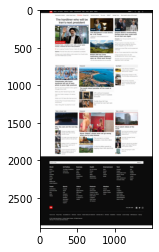

In [3]:
class DSBuilder(DatasetBuilder):
    def setUp(self, driver):
        """
            This method may be overwitten if you need to login to the site
            and navigate to a specific url,
            otherwise it just returns 
        """
        
        driver.set_window_size(width=1500, height=2900)
        logger.info(f'getting url: {self.url}')
        self.driver.get(self.url)
        sleep(3.0)
        maximize_window(driver=driver, extend_pix=0)
        
with DSBuilder(url=SITE_URL, dataset_name=DATASET_NAME, headless=True) as builder:
    plt.imshow(plt.imread(f'dataset/images/{DATASET_NAME}.png'))
    login_df = builder.dataset
    login_json = builder.dataset_json

  

In [4]:
PREDICT_URL

'http://localhost:5000/predict'

### Predict: sending json to backend and getting predictions

In [5]:
%%time

response = requests.post(
    PREDICT_URL, data=json.dumps(login_json)
)

if response.status_code == 200:
    display(json.loads(response.text))
else:
    raise Exception(response.text)

[{'element_id': '7898362041410434018957616040',
  'x': 0.0,
  'y': 1946.953125,
  'width': 1500.0,
  'height': 918.0,
  'predicted_label': 'radiobutton',
  'predicted_probability': 0.9862552881,
  'sort_key': 1377000.0},
 {'element_id': '6375869989410434001647220520',
  'x': 519.984375,
  'y': 1363.953125,
  'width': 460.03125,
  'height': 259.015625,
  'predicted_label': 'link',
  'predicted_probability': 0.9130814672,
  'sort_key': 119155.2817382812},
 {'element_id': '1131512398410434009861332207',
  'x': 519.984375,
  'y': 762.53125,
  'width': 460.03125,
  'height': 259.015625,
  'predicted_label': 'link',
  'predicted_probability': 0.9130814672,
  'sort_key': 119155.2817382812},
 {'element_id': '8265990889410434003108544532',
  'x': 200.0,
  'y': 197.0,
  'width': 446.671875,
  'height': 251.5,
  'predicted_label': 'link',
  'predicted_probability': 0.9130814672,
  'sort_key': 112337.9765625},
 {'element_id': '8631178152410434003579869455',
  'x': 666.65625,
  'y': 401.765625,
  '

Wall time: 4.41 s


In [6]:
response

<Response [200]>

In [7]:
print('Elapsed time:', dt.datetime.now() - START_DT)

Elapsed time: 0:00:16.073886


In [8]:
predictions_df = pd.DataFrame(json.loads(response.text))


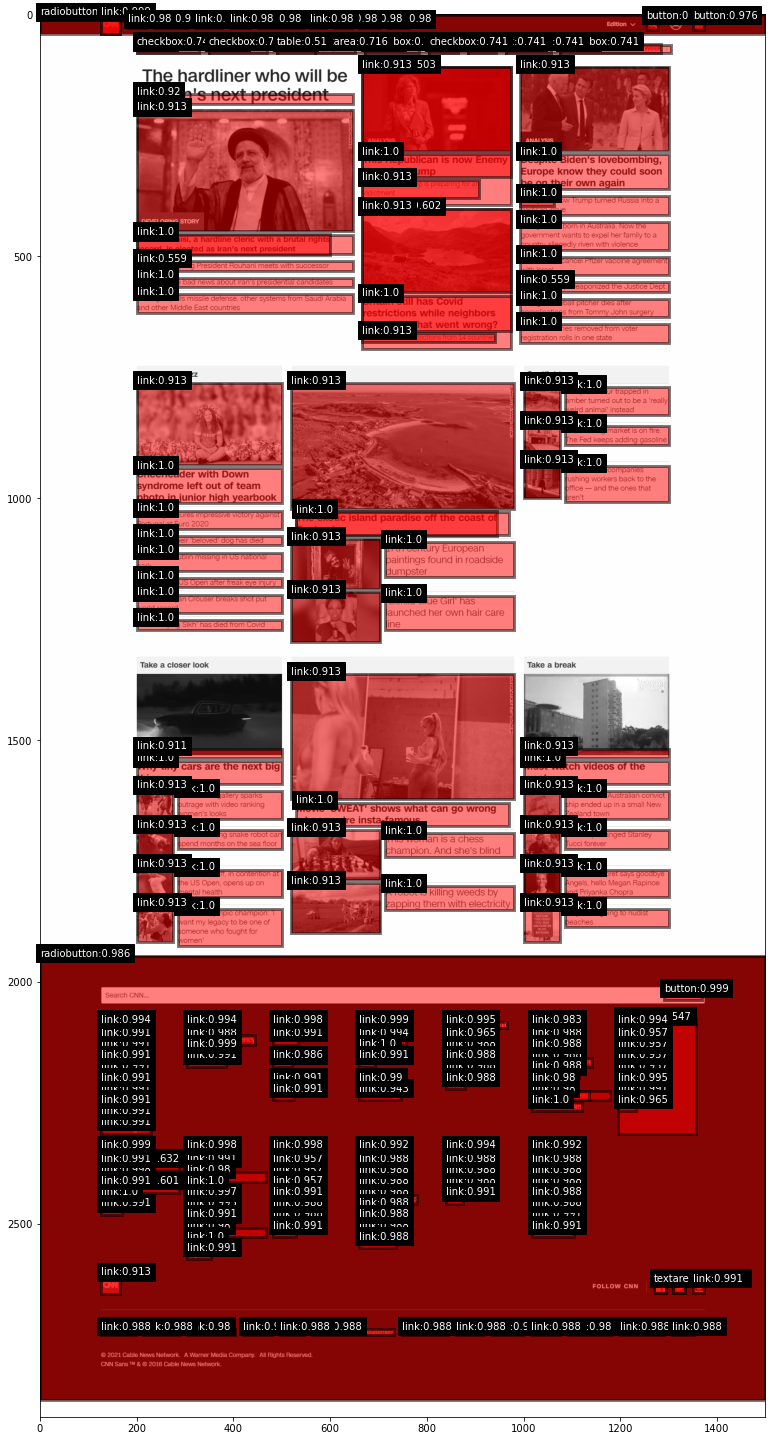

In [9]:
img = load_gray_image(f'dataset/images/{DATASET_NAME}.png')
plt.figure(figsize=(13,300))
plt.imshow(img, cmap='gray')

axes = plt.gca()

for _, r in predictions_df.iterrows():
    patch = Rectangle((r.x, r.y), r.width, r.height, linewidth=3, alpha=.5, facecolor='red', edgecolor='black')
    axes.add_patch(patch)
    
    axes.text(r.x, r.y, r.predicted_label + ':' +str(round(r.predicted_probability, 3)), backgroundcolor='black', color='white')
    